In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy 
import warnings
import cProfile

from time import time

from astropy.stats import sigma_clip
from astropy.table import Table, Column, vstack

import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from astroML.stats import binned_statistic_2d

from asap import io
from asap import smf 
from asap import shmr
from asap import config
from asap import fitting
from asap import ensemble
from asap import plotting
from asap.parameters import AsapParams
from asap.likelihood import ln_likelihood, ln_probability
from asap.predictions import (predict_mstar_basic, predict_smf, predict_mhalo,
                              predict_dsigma_profiles, make_model_predictions)

plt.rc('text', usetex=True)

from palettable.cartocolors.qualitative import Safe_10, Vivid_10
color_circle = Safe_10.mpl_colors
color_circle_2 = Vivid_10.mpl_colors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Figures that compare the observed and predicted T-SHMR and SHMR

In [2]:
test_dir = '../model'

# The configuration file
config_file = os.path.join(test_dir, 'asap_test_1.yaml')

# Initialize the model, load the data
cfg, params, obs_data, um_data = fitting.initial_model(config_file, verbose=True)


# The results of the final sampling process
result_file = os.path.join(test_dir, 'asap_test_1_sample.npz')

# Load in the final sampling results
(mod_result_samples, 
 mod_result_chains, 
 mod_result_lnprob, 
 mod_result_best, _, _) = io.load_npz_results(result_file)

# Predict the stellar mass in inner and outer apertures
logms_inn, logms_tot, sig_logms, mask_use = predict_mstar_basic(
    um_data['um_mock'], mod_result_best, min_logms=10.5,
    logmh_col=cfg['um']['logmh_col'], min_scatter=cfg['um']['min_scatter'],
    pivot=cfg['um']['pivot_logmh'])

# Predict the SMFs and DeltaSigma profiles
um_smf_tot, um_smf_inn, um_dsigma = make_model_predictions(
    mod_result_best, cfg, obs_data, um_data)

# Check the likelihood for SMF and DeltaSigma profiles
lnlike_smf, lnlike_dsigma = ln_likelihood(
    mod_result_best, cfg, obs_data, um_data, sep_return=True)

# The useful part of the mock catalog
um_mock_use = um_data['um_mock'][mask_use]

print("\n# Best parameters: ", mod_result_best)
print("# ln(Likelihood) for SMFs   : %8.4f" % lnlike_smf)
print("# ln(Likelihood) for DSigma : %8.4f" % lnlike_dsigma)

# Running model: asap_test_1
#    Will use emcee as sampler ...
#    Use   256 walkers with    snooker moves for   180 x  3 steps of burn-in
#    Use   256 walkers with        kde moves for   400 steps of sampling

# Observations:
# Galaxy catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# DSigma results: s16a_wide2_dsigma_logm11.6_12_bins.npy
# SMF of inner Mstar: s16a_wide2_massive_smf_m10_11.6.npy
# SMF of total Mstar: s16a_wide2_massive_smf_mmax_11.6.npy
# Covariances for SMFs: s16a_wide2_massive_smf_mmax_m10_cov.npy
# Reference SMF: primus_smf_z0.3_0.4.fits
# Column of inner Mstar: logm_10
# Column of total Mstar: logm_max

# UniverseMachine:
# Galaxy catalog : um_smdpl_insitu_exsitu_0.7124_basic_logmp_11.5_short.npy
# DSigma results : um_smdpl_insitu_exsitu_0.7124_basic_logmp_11.5_50m_r_0.08_50_22bins.npy
# Volumn of the simulation:    205348196.23 Mpc^3
# Halo mass : logmh_host
# Stellar mass : logms_tot
# There are 12 DSigma profiles in this sample
# SMF for total stella

### Compare the TSHMR

In [5]:
shmr_a, shmr_b = mod_result_best[0], mod_result_best[1]
sigms_a, sigms_b = mod_result_best[2], mod_result_best[3]

# Predicted total stellar mass in the halo 
logms_halo_mod_all = shmr_a * (um_mock_use['logmh_host'] - cfg['um']['pivot_logmh']) + shmr_b

# Select the central galaxies
mask_cen = um_mock_use['upid'] == -1
print("# Number of central galaxies: %d" % mask_cen.sum())

logmh_vir = um_mock_use['logmh_vir']
logmh_vir_cen = um_mock_use[mask_cen]['logmh_vir']

# Halo mass bins
logmh_bin = np.linspace(12.0, 14.8, 10)

# For central
idx_logmh_cen = np.digitize(logmh_vir_cen, logmh_bin)

logmh_cen_avg = [np.nanmean(logmh_vir_cen[idx_logmh_cen == k])
                 for k in range(len(logmh_bin))]
logms_cen_avg = [np.nanmean(logms_halo_mod_all[mask_cen][idx_logmh_cen == k])
                for k in range(len(logmh_bin))]
logms_cen_sig = [np.nanstd(logms_halo_mod_all[mask_cen][idx_logmh_cen == k])
                for k in range(len(logmh_bin))]

# Number of central galaxies: 1066604


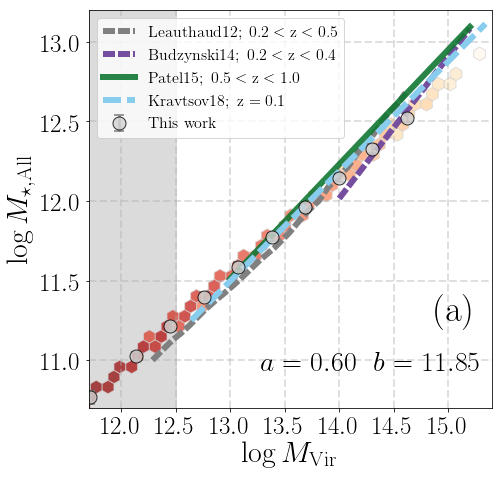

In [8]:
fig_1 = plt.figure(figsize=(7, 6.5))
fig_1.subplots_adjust(left=0.195, right=0.995, bottom=0.145, top=0.995, wspace=0.00, hspace=0.00)
ax1 = fig_1.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

    
# Shade the region where sample is not mass complete 
ax1.fill_between([11.50, 12.50], [10.50, 10.5], [13.5, 13.5],
                 color='lightgray', edgecolor='k', alpha=0.8)

# Show the density distribution of central galaxies using hexbin
ax1.hexbin(logmh_vir_cen, logms_halo_mod_all[mask_cen], 
           gridsize=[35, 18], cmap='OrRd', edgecolor='lightgray', 
           alpha=0.7, mincnt=1, bins='log')

logms_arr = np.linspace(11.5, 14.0, 100)

# Hilton + 2013
#ax1.plot(14.86 + 0.9 * (logms_arr - 13.18) + m500c_to_m200c(),
#         logms_arr + imf_corr_to_chab(kind='salpeter'),
#         c=color_circle[8], linewidth=5, alpha=0.8, 
#         label=r'$\mathrm{Hilton13;\ 0.3<z<1.0}$')

# van der Burg + 2014
#ax1.plot(logmh_arr, 0.59 * (logmh_arr - 14.15) + 12.44,
#         c=color_circle[8], linewidth=5, alpha=0.8, 
#         label=r'$\mathrm{van\ der\ Burg14;\ z=1.0}$')

# Leauthaud + 2012
l12_z1 = Table.read('../data/leauthaud12_integrated_z1.ascii', format='ascii')
l12_m200c = np.log10(l12_z1['col1']) + shmr.m500c_to_m200c()
# Correction for BC03 --> FSPS model
l12_ms_all = np.log10(l12_z1['col1'] * l12_z1['col2']) + 0.10

ax1.plot(l12_m200c, l12_ms_all, c='grey', linewidth=6, alpha=1.0, 
         label=r'$\mathrm{Leauthaud12;\ 0.2<z<0.5}$', linestyle='--', dashes=[2,0.5])

# Budzynski + 2014
logmh_arr = np.linspace(14.0, 15.2, 100)
ax1.plot(logmh_arr, 0.89 * (logmh_arr - np.log10(3.0E14)) + 12.44,
         c=color_circle_2[8], linewidth=6, alpha=1.0, 
         label=r'$\mathrm{Budzynski14;\ 0.2<z<0.4}$',
         linestyle='--', dashes=[2,0.5])

# Patel + 2015; 
logmh_arr = np.linspace(13.0, 15.2, 100)
ax1.plot(logmh_arr, 0.72 * logmh_arr + 2.20 + shmr.imf_corr_to_chab(kind='kroupa'),
         c=color_circle[3], linewidth=6, alpha=0.9, 
         label=r'$\mathrm{Patel15;\ 0.5<z<1.0}$', linestyle='-')

# Kravtsov + 2018
logmh_arr = np.linspace(12.5, 15.2, 100)
ax1.plot(logmh_arr + shmr.m500c_to_m200c(), 
         shmr.kravtsov18_m500_to_mbcg(logmh_arr, tot=True) + 0.05 + shmr.sps_corr_to_bc03(kind='pegase'),
         c=color_circle[0], linewidth=6, alpha=1.0, 
         label=r'$\mathrm{Kravtsov18;\ z=0.1}$', linestyle='-.', dashes=[3,1])

    
ax1.errorbar(logmh_cen_avg, logms_cen_avg, yerr=np.asarray(logms_cen_sig) / 2.0, fmt='o', 
             ecolor='gray', elinewidth=2.5, capsize=5, capthick=2.0,
             color='lightgray', markersize=13, alpha=0.8,
             markeredgecolor='k', label=r'$\mathrm{This\ work}$')

_ = ax1.text(0.70, 0.08, r"$a=%5.2f\ \ b=%5.2f$" % (shmr_a, shmr_b),
             verticalalignment='bottom', horizontalalignment='center',
             fontsize=28, transform=ax1.transAxes)

ax1.legend(loc='upper left', fontsize=16)

ax1.set_xlim(11.7, 15.4)
ax1.set_ylim(10.7, 13.2)

ax1.set_xlabel(r'$\log M_{\mathrm{Vir}}$', fontsize=30)
ax1.set_ylabel(r'$\log M_{\star, \rm All}$', fontsize=30)

_ = ax1.text(0.86, 0.22, r"$(\mathrm{a})$", fontsize=36, transform=ax1.transAxes)

### Compare the SHMR: MVir v.s. M*

In [32]:
# Group galaxies into halo mass bins
logmh_bin = np.linspace(12.4, 14.8, 8)
idx_logmh_cen = np.digitize(logmh_vir_cen, logmh_bin)

# Mean logM*,tot and its scatter at fixed halo mass
logmh_avg_bin = [np.nanmean(logmh_vir_cen[idx_logmh_cen == k])
                 for k in range(len(logmh_bin))]
logms_tot_avg = [np.nanmean(logms_tot[mask_cen][idx_logmh_cen == k])
                for k in range(len(logmh_bin))]
logms_tot_sig = [np.nanstd(logms_tot[mask_cen][idx_logmh_cen == k])
                for k in range(len(logmh_bin))]


# Group galaxies into stellar mass bins
logms_bin = np.linspace(11.4, 12.2, 8)
idx_logms_cen = np.digitize(logms_tot[mask_cen], logms_bin)

# Mean logMVir and its scatter at fixed stellar mass
logms_tot_bin = [np.nanmean(logms_tot[mask_cen][idx_logms_cen == k])
                 for k in range(len(logms_bin))]
logmh_avg = [np.nanmean(logmh_vir_cen[idx_logms_cen == k])
             for k in range(len(logms_bin))]
logmh_sig = [np.nanstd(logmh_vir_cen[idx_logms_cen == k])
             for k in range(len(logms_bin))]

In [35]:
print(logmh_sig)

[0.3780776312497354, 0.28333047024340746, 0.2861333856753778, 0.2816329414905568, 0.2877862147003275, 0.2653500295443438, 0.24804757835962354, 0.23173614941838308]


In [34]:
smhr_mvir_mmax = Table()
smhr_mvir_mmax.add_column(Column(data=logmh_avg_bin, name='logmvir'))
smhr_mvir_mmax.add_column(Column(data=logms_tot_avg, name='logmmax_avg'))
smhr_mvir_mmax.add_column(Column(data=logms_tot_sig, name='logmmax_sig'))

np.save('asap_smdpl_shmr_mvir_mmax.npy', np.asarray(smhr_mvir_mmax))

11.59479441143696 -1.7586819650465169 1.950678487725293 3.359137812415764 0.5038279570011127


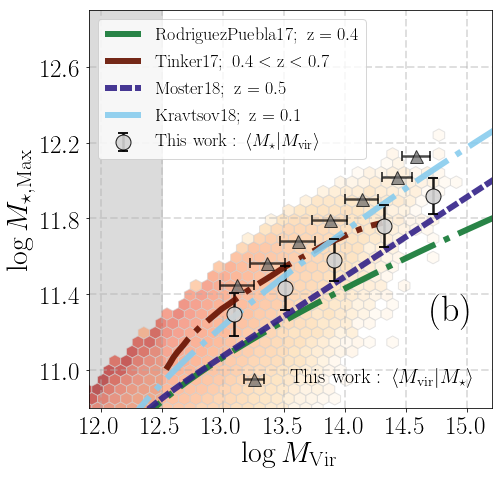

In [16]:
fig_2 = plt.figure(figsize=(7, 6.5))
fig_2.subplots_adjust(left=0.195, right=0.995, bottom=0.145, top=0.995, wspace=0.00, hspace=0.00)
ax1 = fig_2.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

ax1.yaxis.set_ticks([11.0, 11.4, 11.8, 12.2, 12.6])
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

# Shade the region where sample is not mass complete 
ax1.fill_between([11.50, 12.50], [10.50, 10.5], [13.5, 13.5],
                 color='lightgray', edgecolor='k', alpha=0.8)

# Show the density distribution of central galaxies using hexbin
ax1.hexbin(logmh_vir_cen, logms_tot[mask_cen], 
           gridsize=[40, 18], cmap='OrRd', edgecolor='lightgray', 
           alpha=0.6, mincnt=3, bins='log')


logms_arr = np.linspace(11.4, 12.4, 100)
logmh_arr = np.linspace(11.4, 15.4, 100)

# Behroozi + 2013; with ICL
#b13_icl_z1, b13_icl_z2, b13_icl_z3, b13_icl_z4 = shmr.behroozi_mh_to_ms_icl()
#ax1.plot(b13_icl_z3['col1'], b13_icl_z3['col3'] + 0.05,
#         linewidth=5, alpha=0.9, 
#         label=r'$\mathrm{Behroozi13;\ z=0.4;\ ICL}$',
#         c=color_circle[0], linestyle='--', dashes=[4,1])

# Rodriguez-Puebla + 2015; red galaxies
#ax1.plot(logmh_arr, 
#         puebla15_mh_to_ms(logmh_arr, kind='red') + 0.05,
#         linewidth=3, alpha=0.8, 
#         label=r'$\mathrm{RodriguezPuebla15;\ z=0.1;\ Red}$',
#         c=color_circle[1])

# Rodriguez-Puebla + 2017
l1, = ax1.plot(logmh_arr + np.log10(shmr.small_h_corr(0.7, mh=True)), 
               shmr.puebla17_mh_to_ms(logmh_arr, redshift=0.4) + np.log10(shmr.small_h_corr(0.678)) + 0.07,
               linewidth=6.0, alpha=0.9, label=r'$\mathrm{RodriguezPuebla17;\ z=0.4}$',
               c=color_circle[3], linestyle='-.')

# Tinker + 2017
tinker17_mh_to_ms, tinker17_ms_to_mh = shmr.tinker17_shmr()
l2, = ax1.plot(tinker17_mh_to_ms['logmh'], 
               tinker17_mh_to_ms['logms'] + shmr.imf_corr_to_chab(kind='kroupa') + 0.05, 
               linewidth=6.0, alpha=0.9, label=r'$\mathrm{Tinker17;\ 0.4<z<0.7}$',
               c=color_circle[9], linestyle='-.')

# Moster + 2018
l3, = ax1.plot(logmh_arr + np.log10(shmr.small_h_corr(0.7, mh=True)), 
               shmr.moster18_mh_to_ms(logmh_arr, redshift=0.4) + np.log10(shmr.small_h_corr(0.678)) + 0.07, 
               linewidth=6.0, alpha=0.9, label=r'$\mathrm{Moster18;\ z=0.5}$',
               c=color_circle[4], linestyle='--', dashes=[2,0.5])

# Kravtsov + 2018
l4, = ax1.plot(logmh_arr + shmr.m500c_to_m200c(), 
               shmr.kravtsov18_mh_to_ms(logmh_arr, kind='200c', scatter=True) + 0.05 + shmr.sps_corr_to_bc03(kind='pegase'), 
               linewidth=6.0, alpha=0.9, label=r'$\mathrm{Kravtsov18;\ z=0.1}$',
               c=color_circle[0], linestyle='-.')

# This work
shmr1 = ax1.errorbar(logmh_avg_bin[2:], logms_tot_avg[2:], 
                     yerr=np.asarray(logms_tot_sig[2:]) / 2.0, fmt='o', 
                     ecolor='k', elinewidth=2.5, capsize=5, capthick=2.0,
                     color='lightgray', markersize=15, alpha=0.9,
                     markeredgecolor='k', 
                     label=r'$\mathrm{This\ work:\ }\left\langle M_{\star} | M_{\rm vir} \right\rangle$')

legend1 = ax1.legend(handles=[l1, l2, l3, l4, shmr1], loc='upper left', fontsize=18)

# This work
shmr2 = ax1.errorbar(logmh_avg[1:], logms_tot_bin[1:], 
                     xerr=np.asarray(logmh_sig[1:]) / 2.0, fmt='^', 
                     ecolor='k', elinewidth=2.5, capsize=5, capthick=2.0,
                     color='dimgray', markersize=13, alpha=0.7,
                     markeredgecolor='k', 
                     label=r'$\mathrm{This\ work:\ }\left\langle M_{\rm vir} | M_{\star} \right\rangle$')

from matplotlib.legend import Legend
legend2 = Legend(ax1, [shmr2], 
                 [r'$\mathrm{This\ work:\ }\left\langle M_{\rm vir} | M_{\star} \right\rangle$'],
                 loc='lower right', frameon=False, fontsize=20)
ax1.add_artist(legend2);

ax1.set_xlim(11.9, 15.2)
ax1.set_ylim(10.8, 12.9)

_ = ax1.set_xlabel(r'$\log M_{\mathrm{Vir}}$', fontsize=30)
_ = ax1.set_ylabel(r'$\log M_{\star, \rm Max}$', fontsize=30)

_ = ax1.text(0.85, 0.22, r"$(\mathrm{b})$", fontsize=36, transform=ax1.transAxes)

### Compare the SHMR: M* v.s MVir

Text(0, 0.5, '$\\log M_{\\mathrm{Vir}}$')

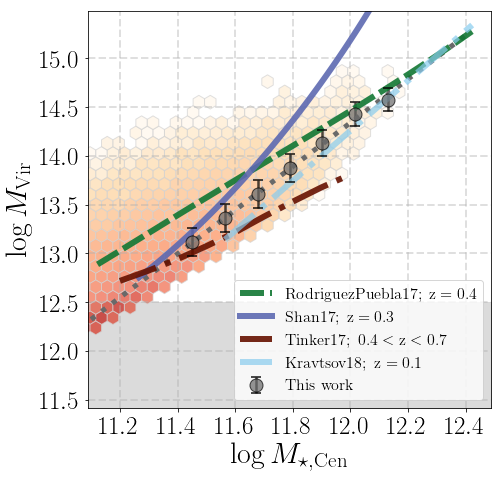

In [17]:
fig_3 = plt.figure(figsize=(7, 6.5))
fig_3.subplots_adjust(left=0.195, right=0.995, bottom=0.145, top=0.995, wspace=0.00, hspace=0.00)
ax1 = fig_3.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

# Shade the region where sample is not mass complete 
ax1.fill_between([11.00, 12.50], [11.2, 11.2], [12.5, 12.5],
                 color='lightgray', edgecolor='k', alpha=0.8)

# Show the density distribution of central galaxies using hexbin
ax1.hexbin(logms_tot[mask_cen], logmh_vir_cen, 
           gridsize=[45, 18], cmap='OrRd', edgecolor='lightgray', 
           alpha=0.7, mincnt=3, bins='log')

logms_arr = np.linspace(11.1, 12.4, 100)
logmh_arr = np.linspace(11.4, 15.4, 100)

# Fit a simple linear relation
mask_fit = (logms_tot[mask_cen] >= 11.5)
poly_a, poly_b = np.polyfit(logms_tot[mask_cen][mask_fit], logmh_vir_cen[mask_fit], 1)
ax1.plot(logms_arr, poly_a * logms_arr + poly_b, c='dimgray', linestyle=':', linewidth=5.0)

# Rodriguez-Puebla + 17
ax1.plot(logms_arr + np.log10(shmr.small_h_corr(0.678)) + 0.05, 
         shmr.puebla17_ms_to_mh(logms_arr, redshift=0.4) + np.log10(shmr.small_h_corr(0.678, mh=True)),
         linewidth=6, alpha=0.9, label=r'$\mathrm{RodriguezPuebla17;\ z=0.4}$',
         c=color_circle[3], linestyle='--', dashes=[4,1])

# Shan + 2017
ax1.plot(logms_arr + 0.05 + shmr.imf_corr_to_chab(kind='kroupa') + shmr.sps_corr_to_bc03(kind='m05') + np.log10(shmr.small_h_corr(0.673)),
         shmr.shan17_ms_to_mh(logms_arr, redshift=0.3) + np.log10(shmr.small_h_corr(0.673, mh=True)),
         linewidth=6, alpha=0.9, label=r'$\mathrm{Shan17;\ z=0.3}$',
         c=color_circle_2[1])

# Tinker + 2017
tinker17_mh_to_ms, tinker17_ms_to_mh = shmr.tinker17_shmr()
ax1.plot(tinker17_ms_to_mh['logms'] + shmr.imf_corr_to_chab(kind='kroupa') + 0.05, 
         tinker17_ms_to_mh['logmh'],
         linewidth=6, alpha=0.9, label=r'$\mathrm{Tinker17;\ 0.4<z<0.7}$',
         c=color_circle[9], linestyle='-.')

# Kravtsov + 2018
logmh_1 = np.linspace(13.0, 15.2, 100)
ax1.plot(shmr.kravtsov18_m500_to_mbcg(logmh_1) + 0.05 + shmr.sps_corr_to_bc03(kind='pegase'), 
         logmh_1 + shmr.m500c_to_m200c(),
         linewidth=6, alpha=0.7, label=r'$\mathrm{Kravtsov18;\ z=0.1}$',
         c=color_circle[0], linestyle='-.')

# This work
ax1.errorbar(logms_tot_bin, logmh_avg, 
             yerr=np.asarray(logmh_sig) / 2.0, fmt='o', 
             ecolor='k', elinewidth=2.5, capsize=5, capthick=2.0,
             color='dimgray', markersize=13, alpha=0.7,
             markeredgecolor='k', label=r'$\mathrm{This\ work}$')

ax1.legend(loc='lower right', fontsize=16)

ax1.set_xlim(11.09, 12.49)
ax1.set_ylim(11.41, 15.49)

ax1.set_xlabel(r'$\log M_{\star, \rm Cen}$', fontsize=30)
ax1.set_ylabel(r'$\log M_{\mathrm{Vir}}$', fontsize=30)

In [18]:
fig_1.savefig('fig/fig5_a_tshmr.pdf', dpi=120)

fig_2.savefig('fig/fig5_b_shmr.pdf', dpi=120)

fig_3.savefig('fig/fig5_c_shmr.pdf', dpi=120)

### Fit simple functions to the SHMR

In [7]:
from lts_linefit import lts_linefit

mask_s = (logms_tot >= 11.5) & (logms_tot <= 12.2) & mask_cen
mask_h = (logmh_vir >= 13.0) & (logmh_vir <= 14.8) & mask_cen

sigms = logms_tot * 0.0 + 0.03
sigmh = logms_tot * 0.0 + 0.03

# Fit the Mstar v.s. Mvir relation 
p0 = lts_linefit(logms_tot[mask_s], logmh_vir[mask_s], sigms[mask_s], sigmh[mask_s], 
                 pivot=np.median(logms_tot[mask_s]), plot=False)
print(p0.ab, "\n")

# Fit the Mstar v.s. Mvir relation 
p1 = lts_linefit(logmh_vir[mask_h], logms_tot[mask_h], sigmh[mask_h], sigms[mask_h], 
                 pivot=np.median(logmh_vir[mask_h]), plot=False)
print(p1.ab)

/Users/song/Dropbox/work/code/cappellari/lts_fits/lts_linefit.py:138: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ab = np.linalg.lstsq(a*sw[:, None], y*sw)[0]


sig_int:     0.0000      4.7209
Computing sig_int
sig_int:     0.0000      4.7209
sig_int:     0.3751     -0.6331
sig_int:     0.3307     -0.5316
sig_int:     0.1654      0.5937
sig_int:     0.2526     -0.2297
sig_int:     0.2098      0.0677
sig_int:     0.2195     -0.0145
sig_int:     0.2178     -0.0007
sig_int:     0.2177      0.0001
Computing sig_int error
sig_int:     0.2177      0.0128
sig_int:     0.3751     -0.6205
sig_int:     0.2209     -0.0107
sig_int:     0.2194     -0.0011
sig_int:     0.2193      0.0001
Repeat at best fitting solution
sig_int:     0.2177      0.0001
################################# Values and formal errors
 intercept:  13.3962 +/- 0.0022
     slope:  2.49 +/- 0.018
   scatter:  0.2177 +/- 0.0016
Observed rms scatter: 0.232 
y = a + b*(x-pivot) with pivot = 11.6
Spearman r=0.62 and p=0
Pearson r=0.68 and p=0
##########################################################
seconds 78.28
[13.39618031  2.48951499] 

sig_int:     0.0000     35.1411
Computing sig_int

In [11]:
# Fit the Mstar v.s. Mvir relation 
p1 = lts_linefit(logmh_vir[mask_h], logms_tot[mask_h], sigmh[mask_h], sigms[mask_h], 
                 pivot=np.median(logmh_vir[mask_h]), plot=False)
print(p1.ab)

/Users/song/Dropbox/work/code/cappellari/lts_fits/lts_linefit.py:138: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ab = np.linalg.lstsq(a*sw[:, None], y*sw)[0]


sig_int:     0.0000     35.1411
Computing sig_int
sig_int:     0.0000     35.1411
sig_int:     0.2538     -0.4321
sig_int:     0.2507     -0.4183
sig_int:     0.1585      0.4209
sig_int:     0.2048     -0.1349
sig_int:     0.1882      0.0196
sig_int:     0.1903     -0.0022
sig_int:     0.1901     -0.0000
sig_int:     0.1900      0.0009
Computing sig_int error
sig_int:     0.1901      0.0076
sig_int:     0.2538     -0.4245
sig_int:     0.1912     -0.0037
sig_int:     0.1908     -0.0000
sig_int:     0.1907      0.0009
Repeat at best fitting solution
sig_int:     0.1901     -0.0000
################################# Values and formal errors
 intercept:  11.3763 +/- 0.0011
     slope:  0.3578 +/- 0.0033
   scatter:  0.19008 +/- 0.00074
Observed rms scatter: 0.193 
y = a + b*(x-pivot) with pivot = 13.27
Spearman r=0.41 and p=0
Pearson r=0.44 and p=0
##########################################################
seconds 199.13
[11.37625107  0.35781021]


### SHMR using the inner 10 kpc stellar mass

In [10]:
# Group galaxies into halo mass bins
logmh_bin = np.linspace(12.4, 14.8, 8)
idx_logmh_cen = np.digitize(logmh_vir_cen, logmh_bin)

# Mean logM*,inn and its scatter at fixed halo mass
logmh_avg_bin = [np.nanmean(logmh_vir_cen[idx_logmh_cen == k])
                 for k in range(len(logmh_bin))]
logms_inn_avg = [np.nanmean(logms_inn[mask_cen][idx_logmh_cen == k])
                for k in range(len(logmh_bin))]
logms_inn_sig = [np.nanstd(logms_inn[mask_cen][idx_logmh_cen == k])
                for k in range(len(logmh_bin))]


# Group galaxies into stellar mass bins
logms_bin = np.linspace(10.7, 11.7, 8)
idx_logms_cen = np.digitize(logms_inn[mask_cen], logms_bin)

# Mean logMVir and its scatter at fixed stellar mass
logms_inn_bin = [np.nanmean(logms_inn[mask_cen][idx_logms_cen == k])
                 for k in range(len(logms_bin))]
logmh_avg = [np.nanmean(logmh_vir_cen[idx_logms_cen == k])
             for k in range(len(logms_bin))]
logmh_sig = [np.nanstd(logmh_vir_cen[idx_logms_cen == k])
             for k in range(len(logms_bin))]

In [36]:
print(logmh_sig)

[0.3780776312497354, 0.28333047024340746, 0.2861333856753778, 0.2816329414905568, 0.2877862147003275, 0.2653500295443438, 0.24804757835962354, 0.23173614941838308]


In [27]:
smhr_mvir_m10 = Table()
smhr_mvir_m10.add_column(Column(data=logmh_avg_bin, name='logmvir'))
smhr_mvir_m10.add_column(Column(data=logms_inn_avg, name='logm10_avg'))
smhr_mvir_m10.add_column(Column(data=logms_inn_sig, name='logm10_sig'))

np.save('asap_smdpl_shmr_mvir_m10.npy', np.asarray(smhr_mvir_m10))

11.59479441143696 -1.7586819650465169 1.950678487725293 3.359137812415764 0.5038279570011127


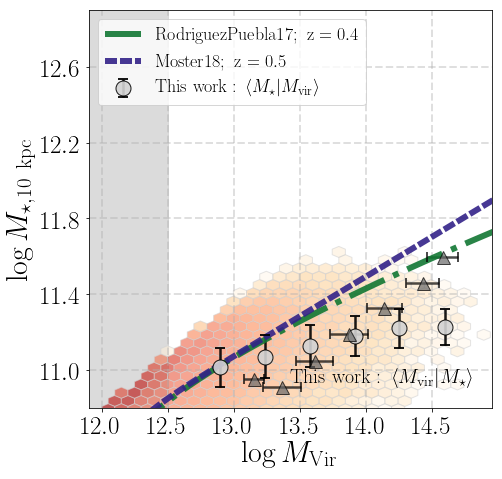

In [37]:
fig_4 = plt.figure(figsize=(7, 6.5))
fig_4.subplots_adjust(left=0.195, right=0.995, bottom=0.145, top=0.995, wspace=0.00, hspace=0.00)
ax1 = fig_4.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

ax1.yaxis.set_ticks([11.0, 11.4, 11.8, 12.2, 12.6])
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

# Shade the region where sample is not mass complete 
ax1.fill_between([11.50, 12.50], [10.50, 10.5], [13.5, 13.5],
                 color='lightgray', edgecolor='k', alpha=0.8)

# Show the density distribution of central galaxies using hexbin
ax1.hexbin(logmh_vir_cen, logms_inn[mask_cen], 
           gridsize=[38, 18], cmap='OrRd', edgecolor='lightgray', 
           alpha=0.6, mincnt=3, bins='log')

logms_arr = np.linspace(11.4, 12.4, 100)
logmh_arr = np.linspace(11.4, 15.4, 100)
# Rodriguez-Puebla + 2017
l1, = ax1.plot(logmh_arr + np.log10(shmr.small_h_corr(0.7, mh=True)), 
               shmr.puebla17_mh_to_ms(logmh_arr, redshift=0.4) + np.log10(shmr.small_h_corr(0.678)) + 0.07,
               linewidth=6.0, alpha=0.9, label=r'$\mathrm{RodriguezPuebla17;\ z=0.4}$',
               c=color_circle[3], linestyle='-.')

# Moster + 2018
l3, = ax1.plot(logmh_arr + np.log10(shmr.small_h_corr(0.7, mh=True)), 
               shmr.moster18_mh_to_ms(logmh_arr, redshift=0.4) + np.log10(shmr.small_h_corr(0.678)) + 0.07, 
               linewidth=6.0, alpha=0.9, label=r'$\mathrm{Moster18;\ z=0.5}$',
               c=color_circle[4], linestyle='--', dashes=[2,0.5])

# This work
shmr1 = ax1.errorbar(logmh_avg_bin[2:], logms_inn_avg[2:], 
                     yerr=np.asarray(logms_inn_sig[2:]) / 2.0, fmt='o', 
                     ecolor='k', elinewidth=2.5, capsize=5, capthick=2.0,
                     color='lightgray', markersize=15, alpha=0.9,
                     markeredgecolor='k', 
                     label=r'$\mathrm{This\ work:\ }\left\langle M_{\star} | M_{\rm vir} \right\rangle$')

legend1 = ax1.legend(handles=[l1, l3, shmr1], loc='upper left', fontsize=18)

# This work
shmr2 = ax1.errorbar(logmh_avg[1:], logms_inn_bin[1:], 
                     xerr=np.asarray(logmh_sig[1:]) / 2.0, fmt='^', 
                     ecolor='k', elinewidth=2.5, capsize=5, capthick=2.0,
                     color='dimgray', markersize=13, alpha=0.7,
                     markeredgecolor='k', 
                     label=r'$\mathrm{This\ work:\ }\left\langle M_{\rm vir} | M_{\star} \right\rangle$')

from matplotlib.legend import Legend
legend2 = Legend(ax1, [shmr2], 
                 [r'$\mathrm{This\ work:\ }\left\langle M_{\rm vir} | M_{\star} \right\rangle$'],
                 loc='lower right', frameon=False, fontsize=20)
ax1.add_artist(legend2);

ax1.set_xlim(11.9, 14.95)
#ax1.set_ylim(10.6, 12.2)
ax1.set_ylim(10.8, 12.9)

_ = ax1.set_xlabel(r'$\log M_{\mathrm{Vir}}$', fontsize=30)
_ = ax1.set_ylabel(r'$\log M_{\star, 10\ \mathrm{kpc}}$', fontsize=30)

Text(0, 0.5, '$\\log M_{\\mathrm{Vir}}$')

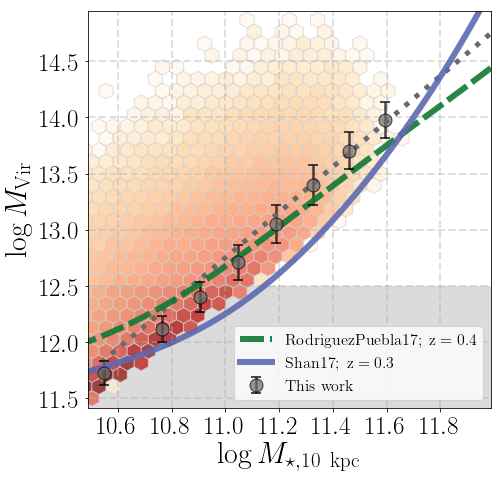

In [20]:
fig_5 = plt.figure(figsize=(7, 6.5))
fig_5.subplots_adjust(left=0.195, right=0.995, bottom=0.145, top=0.995, wspace=0.00, hspace=0.00)
ax1 = fig_5.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

# Shade the region where sample is not mass complete 
ax1.fill_between([10.40, 12.50], [10.40, 10.4], [12.5, 12.5],
                 color='lightgray', edgecolor='k', alpha=0.8)

# Show the density distribution of central galaxies using hexbin
ax1.hexbin(logms_inn[mask_cen], logmh_vir_cen, 
           gridsize=[30, 18], cmap='OrRd', edgecolor='lightgray', 
           alpha=0.7, mincnt=3, bins='log')

logms_arr = np.linspace(10.2, 12.4, 100)
logmh_arr = np.linspace(12.0, 15.4, 100)

# Fit a simple linear relation
mask_fit = (logms_inn[mask_cen] >= 11.5)
poly_a, poly_b = np.polyfit(logms_inn[mask_cen][mask_fit], logmh_vir_cen[mask_fit], 1)
ax1.plot(logms_arr, poly_a * logms_arr + poly_b, c='dimgray', linestyle=':', linewidth=5.0)

# Rodriguez-Puebla + 17
ax1.plot(logms_arr + np.log10(shmr.small_h_corr(0.678)) + 0.05, 
         shmr.puebla17_ms_to_mh(logms_arr, redshift=0.4) + np.log10(shmr.small_h_corr(0.678, mh=True)),
         linewidth=6, alpha=0.9, label=r'$\mathrm{RodriguezPuebla17;\ z=0.4}$',
         c=color_circle[3], linestyle='--', dashes=[4,1])

# Shan + 2017
ax1.plot(logms_arr + 0.05 + shmr.imf_corr_to_chab(kind='kroupa') + shmr.sps_corr_to_bc03(kind='m05') + np.log10(shmr.small_h_corr(0.673)),
         shmr.shan17_ms_to_mh(logms_arr, redshift=0.3) + np.log10(shmr.small_h_corr(0.673, mh=True)),
         linewidth=6, alpha=0.9, label=r'$\mathrm{Shan17;\ z=0.3}$',
         c=color_circle_2[1])

# This work
ax1.errorbar(logms_inn_bin, logmh_avg, 
             yerr=np.asarray(logmh_sig) / 2.0, fmt='o', 
             ecolor='k', elinewidth=2.5, capsize=5, capthick=2.0,
             color='dimgray', markersize=13, alpha=0.7,
             markeredgecolor='k', label=r'$\mathrm{This\ work}$')

ax1.legend(loc='lower right', fontsize=16)

ax1.set_xlim(10.49, 11.99)
ax1.set_ylim(11.41, 14.95)

ax1.set_xlabel(r'$\log M_{\star, 10\ \mathrm{kpc}}$', fontsize=30)
ax1.set_ylabel(r'$\log M_{\mathrm{Vir}}$', fontsize=30)